In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e9/sample_submission.csv
/kaggle/input/playground-series-s3e9/train.csv
/kaggle/input/playground-series-s3e9/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e9/test.csv')
del train['id']

train

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
...,...,...,...,...,...,...,...,...,...
5402,446.0,24.0,79.0,162.0,11.6,967.0,712.0,3,15.42
5403,350.0,0.0,0.0,203.0,0.0,974.0,775.0,180,49.20
5404,295.8,0.0,0.0,185.7,0.0,1076.2,759.3,28,39.30
5405,376.0,93.4,0.0,162.6,11.5,955.8,662.9,28,39.61


In [4]:
# there are duplicates in the training data
# average over the duplicates
predictors = train.columns[:-1].to_list()
train = train.groupby(predictors).agg('mean').reset_index()

<AxesSubplot:>

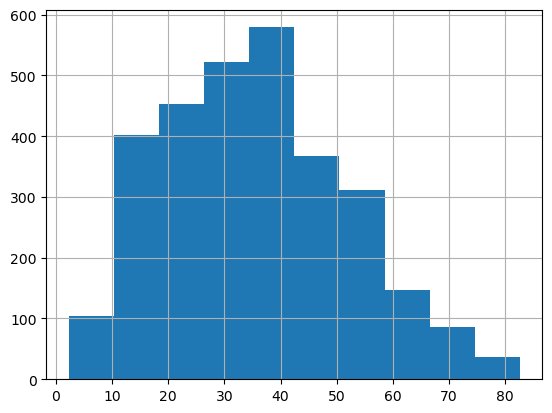

In [5]:
train['Strength'].hist()

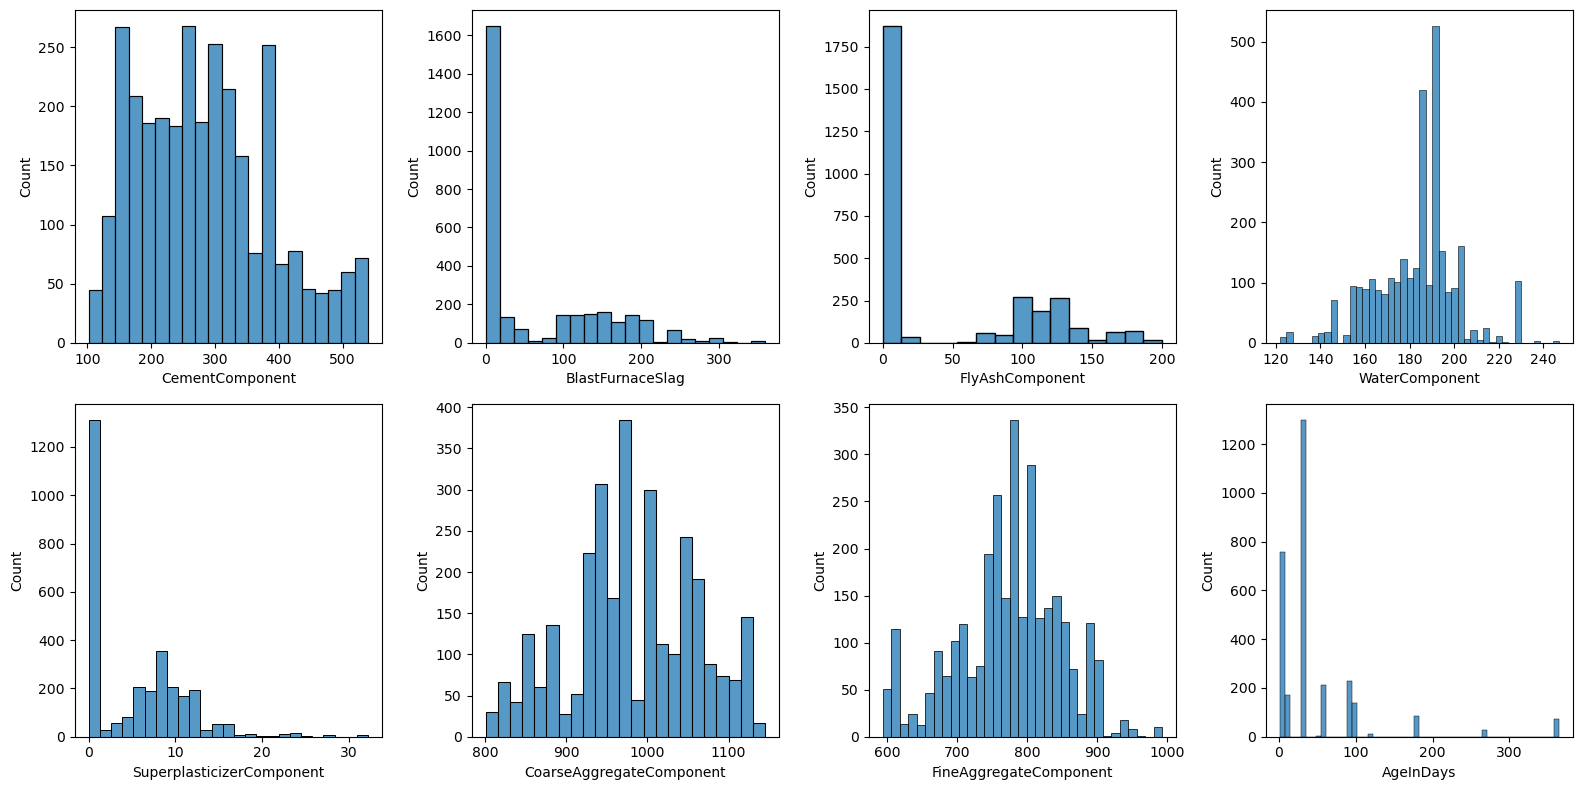

In [6]:
# histograms of predictors
n_rows = 2
n_cols = 4

fig,axs = plt.subplots(n_rows,n_cols,figsize=(4*n_cols,4*n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        col_idx = n_cols*i+j
        _ = sns.histplot(data=train,x=train.columns[col_idx],ax=axs[i][j])
        
fig.tight_layout()

Some of the predictors have a rather larger number of zero values. 

In [7]:
zero_value_cols = ['BlastFurnaceSlag','FlyAshComponent','SuperplasticizerComponent']
for col in zero_value_cols:
    print('Proportion of zero_values observations for col %s: %5.3f' %(col,(train[col]==0).mean()))

Proportion of zero_values observations for col BlastFurnaceSlag: 0.537
Proportion of zero_values observations for col FlyAshComponent: 0.623
Proportion of zero_values observations for col SuperplasticizerComponent: 0.437


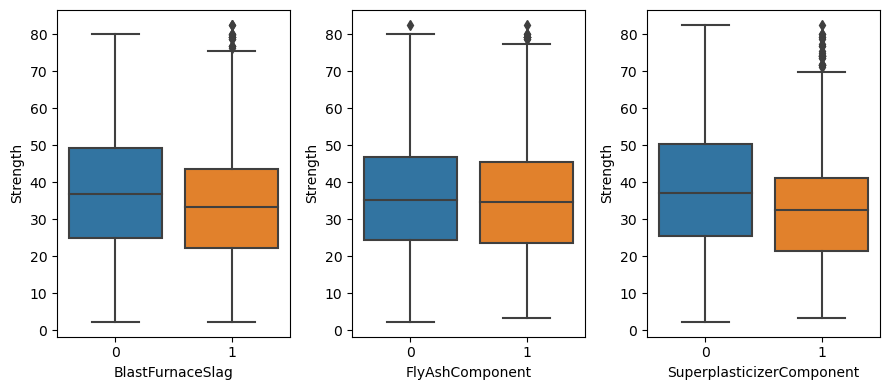

In [8]:
fig,axs = plt.subplots(1,len(zero_value_cols),figsize=(3*len(zero_value_cols),4))
for i,col in enumerate(zero_value_cols):
    indicator = 1*(train[col] == 0)
    _ = sns.boxplot(y=train['Strength'],x=indicator,ax=axs[i])

fig.tight_layout()

Only `SuperplasticizerComponent==0` seems to have some effect on the response. We might use it in a later run. 


Before we go into tuning and fitting an XGboost model, let's look at the correlations among the predictors.This might be relevant when assessing effects through partial dependence plots.

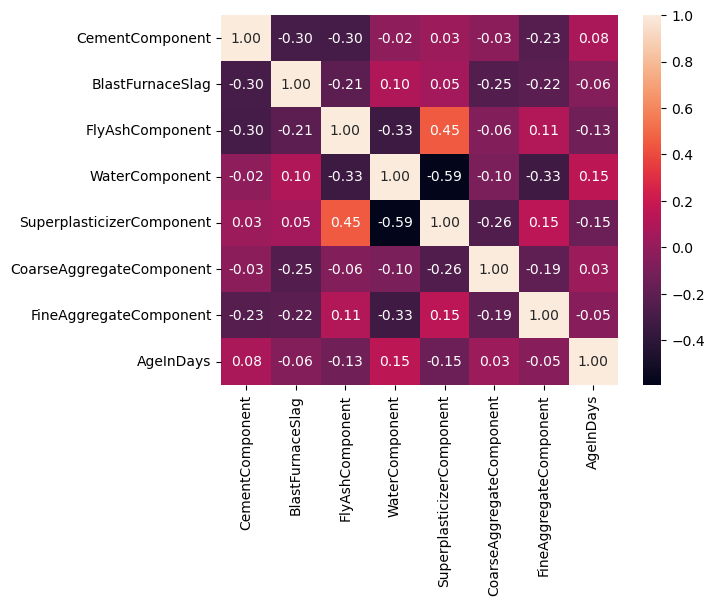

In [9]:
_ = sns.heatmap(
    train.drop('Strength',axis=1).corr(),
    annot=True,
    fmt='.2f'
)

1. It appears that`SuperplasticizerComponent` is somewhat positively correlated with `FlyAshComponent`. This could, however, be due to the large number of zero values in both predictors. 
2. `SuperplasticizerComponent` is negative correlated with `WaterComponent`. This might be something to explore. 

In [10]:
# finally, extract predictors and response.
X = train.drop('Strength',axis=1)
y = train['Strength'].values

In [11]:
monotone_constraints = {col:0 for col in X.columns}
monotone_constraints['CementComponent'] = 1
monotone_constraints['AgeInDays']=1

## XGboost model

### Tuning with hyperopt 

In [12]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import mean_squared_error
from joblib import Parallel,delayed

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from hyperopt.pyll_utils import scope
from typing import Dict,Optional,Union

In [13]:
def fit_model_with_early_stopping(
    X:Union[pd.DataFrame,np.ndarray],
    y:Union[pd.Series,np.ndarray],
    config:Optional[Dict]=None,
    n_jobs:int=1,
    verbose:int=0
) -> XGBRegressor:
    
    # split data into training and validation sets
    # NOTE: this will add some randomness in the final results
    X_train,X_val, y_train, y_val = train_test_split(X,y,test_size=0.1)

    model = XGBRegressor(
        n_estimators = 1500, # use a large number of trees with early stopping
        tree_method='approx',max_depth=10,
        monotone_constraints=monotone_constraints,
        early_stopping_rounds = 10,
        n_jobs=n_jobs
    )
    
    if config:
        model.set_params(**config)
        
    return model.fit(X_train,y_train,eval_set=[(X_val, y_val)],verbose=verbose)
    

In [14]:
def fit_and_test_fold(config:Dict,train_index,test_index) -> float:
    X_train = X.iloc[train_index,:];X_test = X.iloc[test_index,:]
    y_train = y[train_index]; y_test = y[test_index]
    
    # fit model on training data
    model = fit_model_with_early_stopping(X_train,y_train,config)
    
    # generate predictions on test data
    y_test_pred = model.predict(X_test)
    
    # return RMSE
    return np.sqrt(mean_squared_error(y_test,y_test_pred))
    

In [15]:
# loss function
def objective(config:Optional[Dict]=None):
     
    # 8-fold cross-validation: kaggle notebooks have 4 cores available
    cv = KFold(n_splits=8,shuffle=True,random_state=1)
    
    cv_losses = Parallel(n_jobs=4,verbose=0)(
        delayed(fit_and_test_fold)(config,train_index,test_index) for train_index,test_index in cv.split(X)
    )
    
    return {'loss':np.mean(cv_losses),'status': STATUS_OK,'min_RMSE_fold':np.min(cv_losses),'max_RMSE_fold':np.max(cv_losses)}

# search space
search_space = {
    #'n_estimators': scope.int(hp.quniform('n_estimators',100,1500,1)),
    'learning_rate': hp.loguniform('learning_rate',np.log(1e-4),np.log(0.5)),
    #'max_depth': scope.int(hp.quniform('max_depth',1,10,1)), # default value is 6 
    'max_leaves': scope.int(hp.qloguniform('max_leaves',np.log(2),8*np.log(2),1)), # min: 2, max:256
    'subsample':hp.uniform('subsample',0.1,1),
    'colsample_bytree':hp.uniform('colsample_bytree',0.1,1),
    'gamma':hp.loguniform('gamma',np.log(1e-6),np.log(100)),
    'reg_alpha':hp.loguniform('reg_alpha',np.log(1e-6),np.log(100)),
    'reg_lambda':hp.loguniform('reg_lambda',np.log(1e-6),np.log(100)),
    'grow_policy':hp.choice('grow_policy',['depthwise','lossguide']) # 'depthwise' is default
}


trials = Trials()
best = fmin(
    objective,search_space,
    algo=tpe.suggest,
    max_evals = 100,
    trials=trials,
    return_argmin=False,
    rstate=np.random.default_rng(1)
)
best

100%|██████████| 100/100 [20:29<00:00, 12.29s/trial, best loss: 11.902008452334869]


{'colsample_bytree': 0.6179181736702726,
 'gamma': 0.00014546198834329294,
 'grow_policy': 'lossguide',
 'learning_rate': 0.011537532964498349,
 'max_leaves': 10,
 'reg_alpha': 0.00467101620988974,
 'reg_lambda': 5.6428822785239106e-05,
 'subsample': 0.45909483559341735}

In [16]:

results = pd.DataFrame([
    space_eval(search_space,row.to_dict()) for _,row in pd.DataFrame(trials.vals).iterrows()
]) 

results['RMSE'] = [tmp['loss'] for tmp in trials.results]
results['min_RMSE_fold'] = [tmp['min_RMSE_fold'] for tmp in trials.results]
results['max_RMSE_fold'] = [tmp['max_RMSE_fold'] for tmp in trials.results]
results.to_csv('cv_rmse_hyperopt.csv',index=False)
# top 10 configurations
results.sort_values('RMSE',ascending=True).head(10)

,colsample_bytree,gamma,grow_policy,learning_rate,max_leaves,reg_alpha,reg_lambda,subsample,RMSE,min_RMSE_fold,max_RMSE_fold
77,0.617918,0.000145,lossguide,0.011538,10,0.004671,0.000056,0.459095,11.902008,11.175482,12.743917
21,0.948696,0.000009,lossguide,0.019381,21,91.029684,0.000004,0.444029,11.902870,11.109902,12.623161
98,0.634619,0.000028,depthwise,0.006047,9,6.251454,0.000067,0.285588,11.918079,11.093710,12.667464
72,0.702206,0.000019,lossguide,0.004474,13,0.001801,0.000002,0.476777,11.920553,11.164401,12.674741
63,0.889610,0.000060,lossguide,0.012362,5,0.001374,0.000125,0.638391,11.924976,11.183606,12.585124
71,0.688355,0.000217,lossguide,0.003848,8,0.001791,0.000002,0.488725,11.927775,11.168841,12.746594
57,0.961648,0.001040,lossguide,0.007246,4,0.000005,0.000009,0.549028,11.929852,11.185377,12.642522
75,0.790628,0.000007,lossguide,0.109297,11,0.067630,0.000005,0.654856,11.934566,11.098557,12.681752
27,0.600964,0.000038,lossguide,0.033599,38,0.000013,99.531859,0.348047,11.938502,11.190843,12.713608
54,0.996593,0.011018,depthwise,0.017228,12,0.007540,0.000041,0.241347,11.942522,11.203266,12.659357


### Final model

In [17]:
# train model
model = fit_model_with_early_stopping(X,y,best,verbose=10)

# final number of trees
print(len(model.get_booster().get_dump()))

[0]	validation_0-rmse:37.47521
[10]	validation_0-rmse:33.82851
[20]	validation_0-rmse:30.65728
[30]	validation_0-rmse:27.84691
[40]	validation_0-rmse:25.39793
[50]	validation_0-rmse:23.29220
[60]	validation_0-rmse:21.51417
[70]	validation_0-rmse:19.89680
[80]	validation_0-rmse:18.54444
[90]	validation_0-rmse:17.40236
[100]	validation_0-rmse:16.45190
[110]	validation_0-rmse:15.60648
[120]	validation_0-rmse:14.90555
[130]	validation_0-rmse:14.35896
[140]	validation_0-rmse:13.89099
[150]	validation_0-rmse:13.49089
[160]	validation_0-rmse:13.15878
[170]	validation_0-rmse:12.87918
[180]	validation_0-rmse:12.66446
[190]	validation_0-rmse:12.47020
[200]	validation_0-rmse:12.32494
[210]	validation_0-rmse:12.21225
[220]	validation_0-rmse:12.09645
[230]	validation_0-rmse:12.00857
[240]	validation_0-rmse:11.94549
[250]	validation_0-rmse:11.89012
[260]	validation_0-rmse:11.85323
[270]	validation_0-rmse:11.82320
[280]	validation_0-rmse:11.79353
[290]	validation_0-rmse:11.78299
[300]	validation_0-rm

<AxesSubplot:>

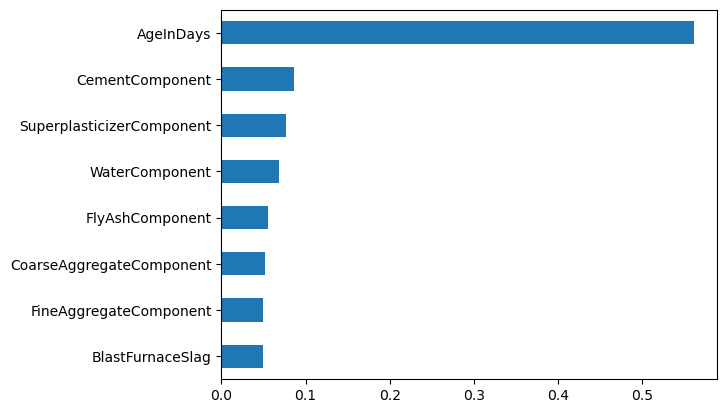

In [18]:
# gain based feature importances - not necessarily the most reliable
feat_imp = pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True)
feat_imp.plot(kind='barh')

We can also generate 1D partial dependence plots. The range of the y-values is a proxy for the extent of the effect.

**Note**: PD plots are not ideal when some of the features are correlated with each other. 

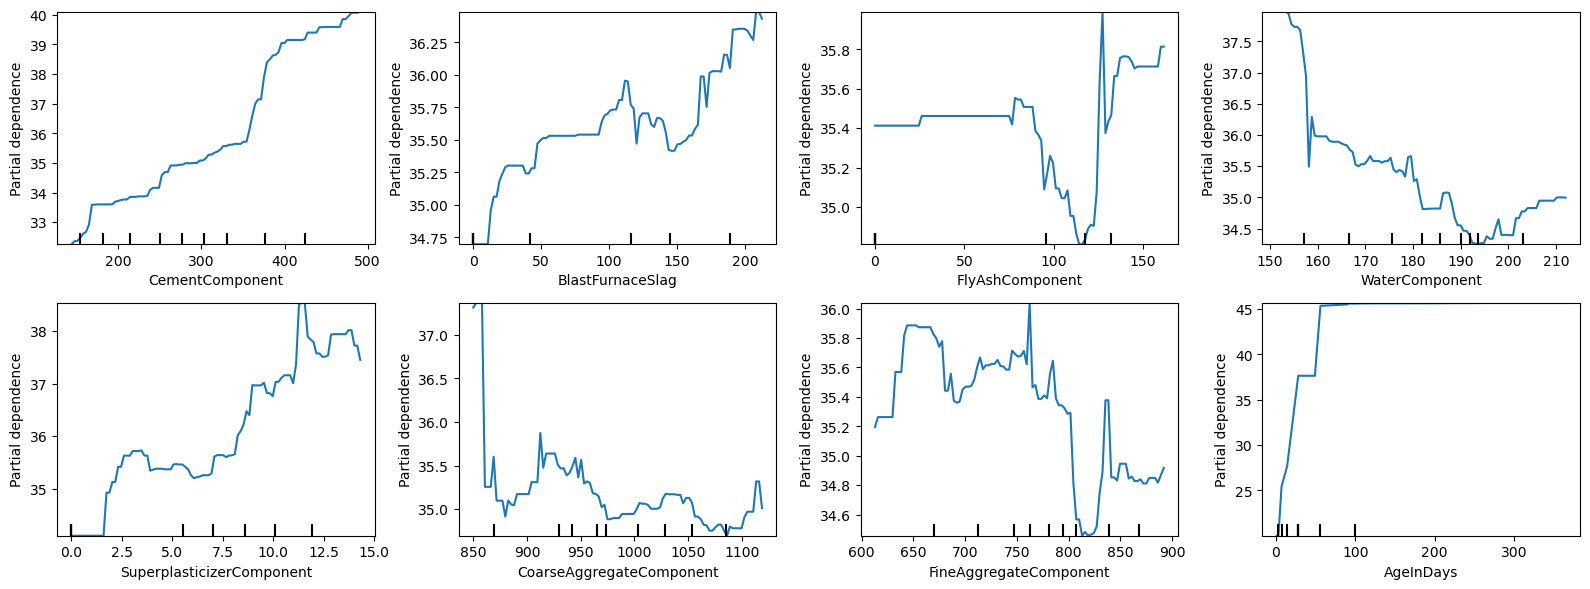

In [19]:
from sklearn.inspection import PartialDependenceDisplay

# 1-D Partial dependence plots
num_rows=2
num_cols=4
fig,axs = plt.subplots(num_rows,num_cols,figsize=(16,6))
for i in range(num_rows):
    for j in range(num_cols):
        # select correct feature
        feature = [X.columns[num_cols*i+j]]
        
        _ = PartialDependenceDisplay.from_estimator(
            model,X,features=feature,
            ax=axs[i,j]
        )

fig.tight_layout()

## Evaluate on test set

In [20]:
test_ids = test['id']
test = test.drop('id',axis=1)

submission = pd.DataFrame({'id':test_ids.values,'Strength':model.predict(test)})
submission.to_csv('submission.csv',index=False)